In [1]:
!pip install frouros

Defaulting to user installation because normal site-packages is not writeable


This analysis is focused on detecting data drift by analyzing the deviations from a moving average of the time series data. The use of the KS test helps in identifying significant changes in the data distribution between consecutive chunks, indicating potential data drift. The moving average helps in smoothing the data to highlight trends, while the deviations capture the irregularities or noise in the data.



/home/wickstjo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Data drift detected between Chunk 1 and Chunk 2 (p-value: 0.0175)
Data drift detected between Chunk 2 and Chunk 3 (p-value: 0.0000)
Data drift detected between Chunk 3 and Chunk 4 (p-value: 0.0001)


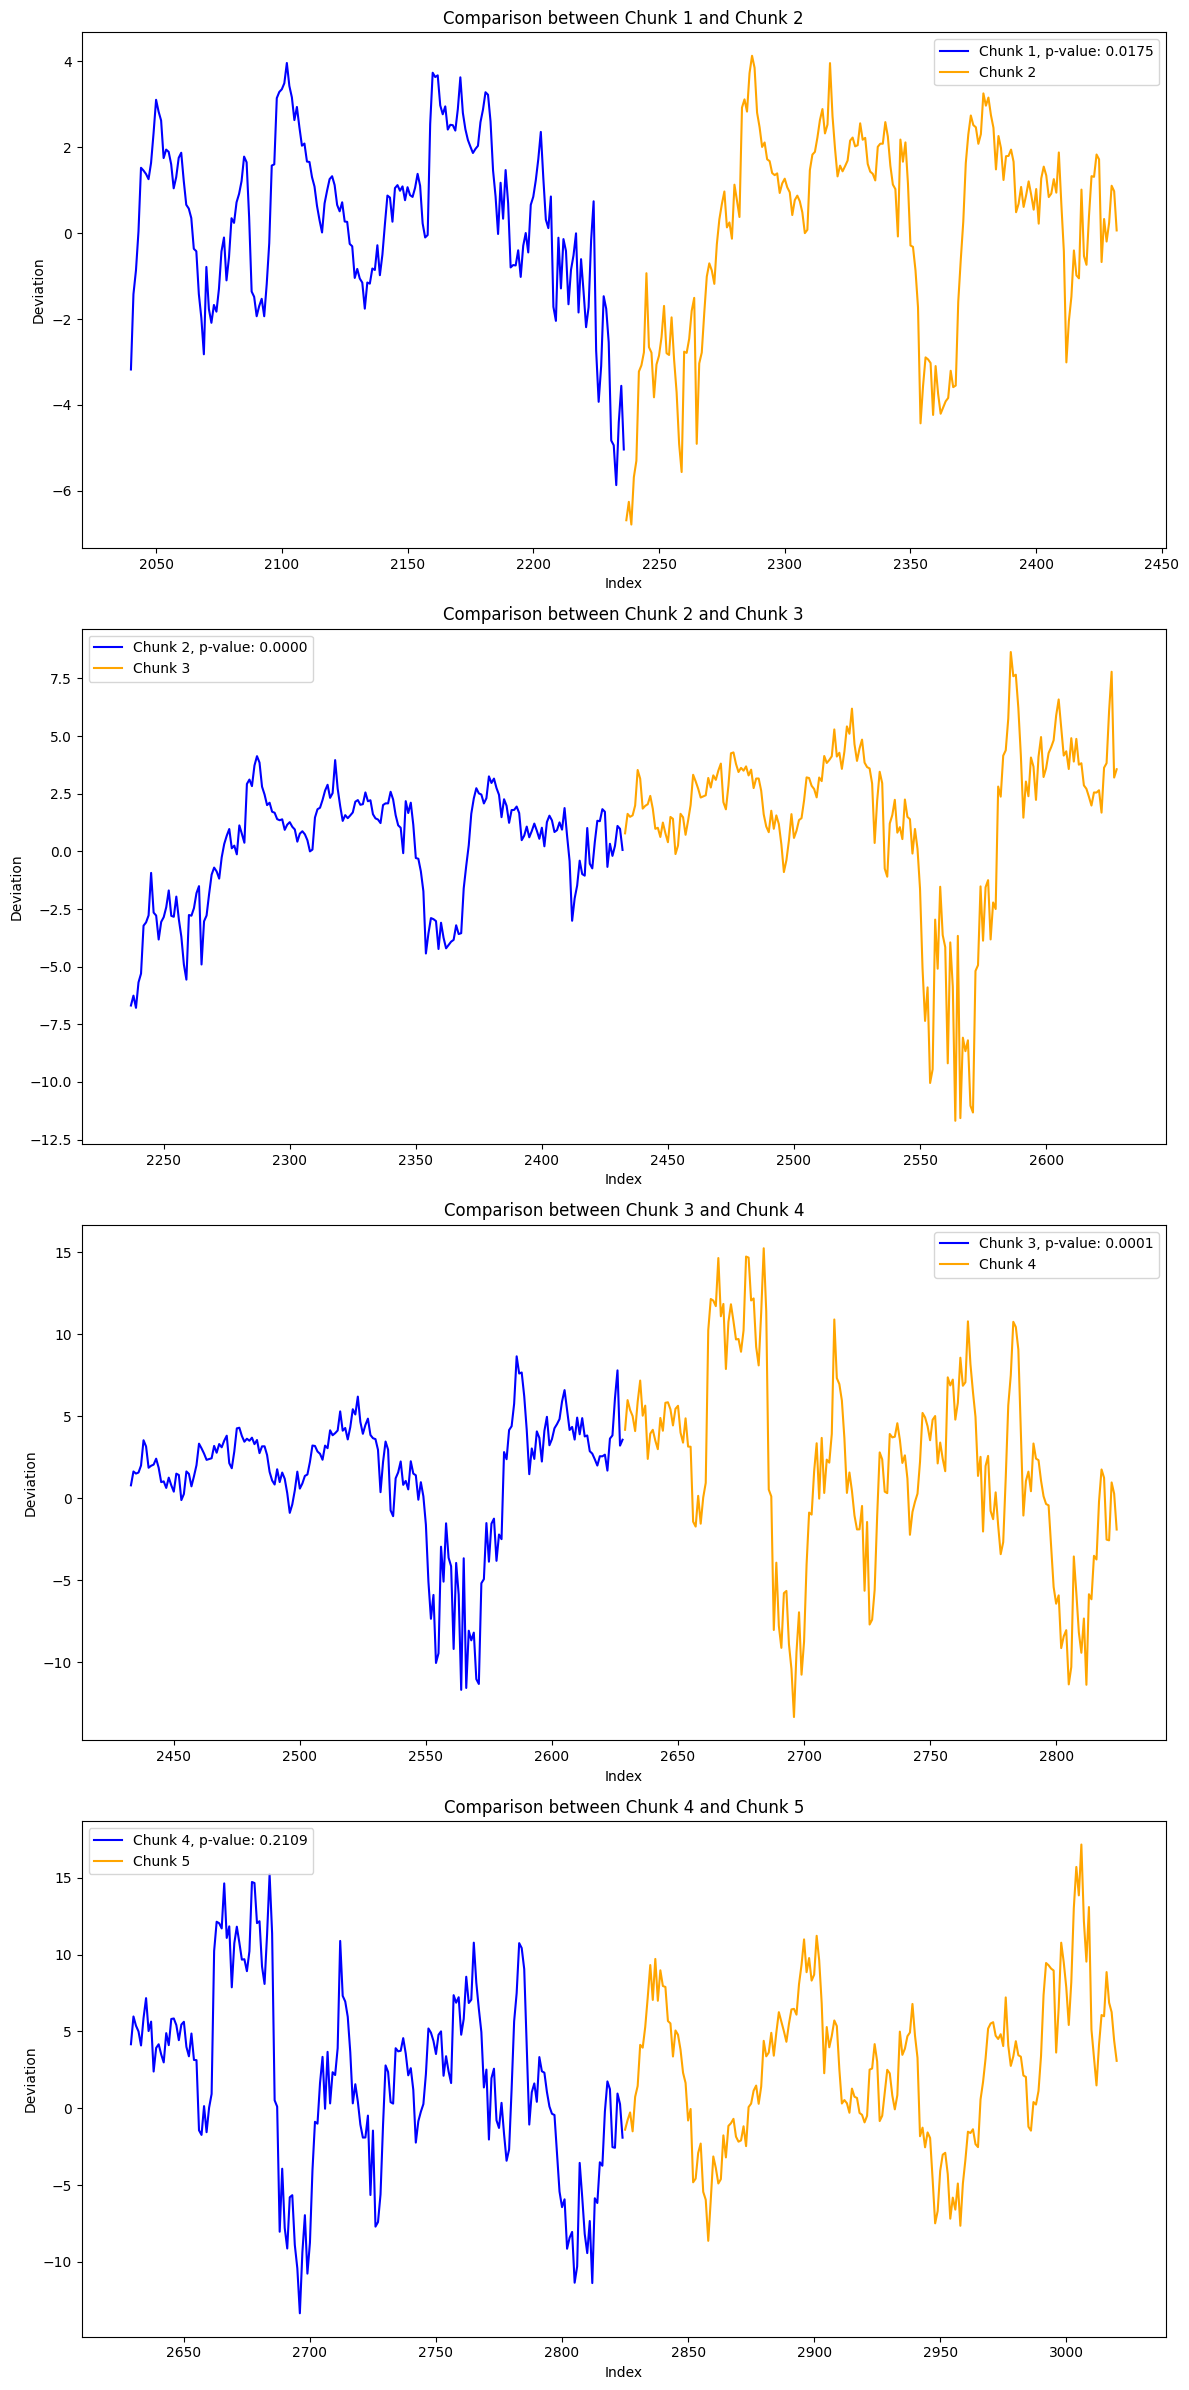

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from frouros.detectors.data_drift import KSTest

class DataDriftDetector:
    def __init__(self, file_path, window_size=20, num_chunks=5):
        self.file_path = file_path
        self.window_size = window_size
        self.num_chunks = num_chunks
        self.data = None
        self.last_1000_data = None
        self.moving_average = None
        self.deviations = None
        self.chunks = None
        self.ks_stats = []
        self.ks_p_values = []

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def calculate_moving_average(self):
        self.moving_average = self.last_1000_data.rolling(window=self.window_size).mean().dropna()

    def calculate_deviations(self):
        self.deviations = self.last_1000_data[self.window_size-1:] - self.moving_average

    def split_chunks(self):
        self.chunks = np.array_split(self.deviations, self.num_chunks)

    def perform_ks_test(self):
        ks_test = KSTest()
        for i in range(len(self.chunks) - 1):
            ks_test.fit(self.chunks[i].values.reshape(-1, 1))
            ks_result, _ = ks_test.compare(self.chunks[i + 1].values.reshape(-1, 1))
            ks_stat = ks_result.statistic[0]
            ks_p_value = ks_result.p_value[0]
            self.ks_stats.append(ks_stat)
            self.ks_p_values.append(ks_p_value)
            if ks_p_value < 0.05:
                print(f"Data drift detected between Chunk {i+1} and Chunk {i+2} (p-value: {ks_p_value:.4f})")

    def plot_results(self):
        fig, axes = plt.subplots(len(self.chunks) - 1, 1, figsize=(12, 6 * (len(self.chunks) - 1)))
        for i in range(len(self.chunks) - 1):
            axes[i].plot(self.chunks[i].index, self.chunks[i], label=f'Chunk {i+1}, p-value: {self.ks_p_values[i]:.4f}', color='blue')
            axes[i].plot(self.chunks[i + 1].index, self.chunks[i + 1], label=f'Chunk {i+2}', color='orange')
            axes[i].set_title(f'Comparison between Chunk {i+1} and Chunk {i+2}')
            axes[i].set_xlabel('Index')
            axes[i].set_ylabel('Deviation')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.calculate_moving_average()
        self.calculate_deviations()
        self.split_chunks()
        self.perform_ks_test()
        self.plot_results()

# Usage
detector = DataDriftDetector('../finance_historical.csv')
detector.run()

The provided code performs data drift detection using the Kolmogorov-Smirnov (KS) test on the residual component of a time series data. It specifically uses STL (Seasonal and Trend decomposition using Loess) decomposition to isolate the residual component, which helps in identifying irregularities or noise in the data that are not explained by trend or seasonal patterns

/home/wickstjo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Data drift detected between Segment 1 and Segment 2 (p-value: 0.0000)
Data drift detected between Segment 2 and Segment 3 (p-value: 0.0004)
Data drift detected between Segment 3 and Segment 4 (p-value: 0.0030)
Data drift detected between Segment 4 and Segment 5 (p-value: 0.0000)


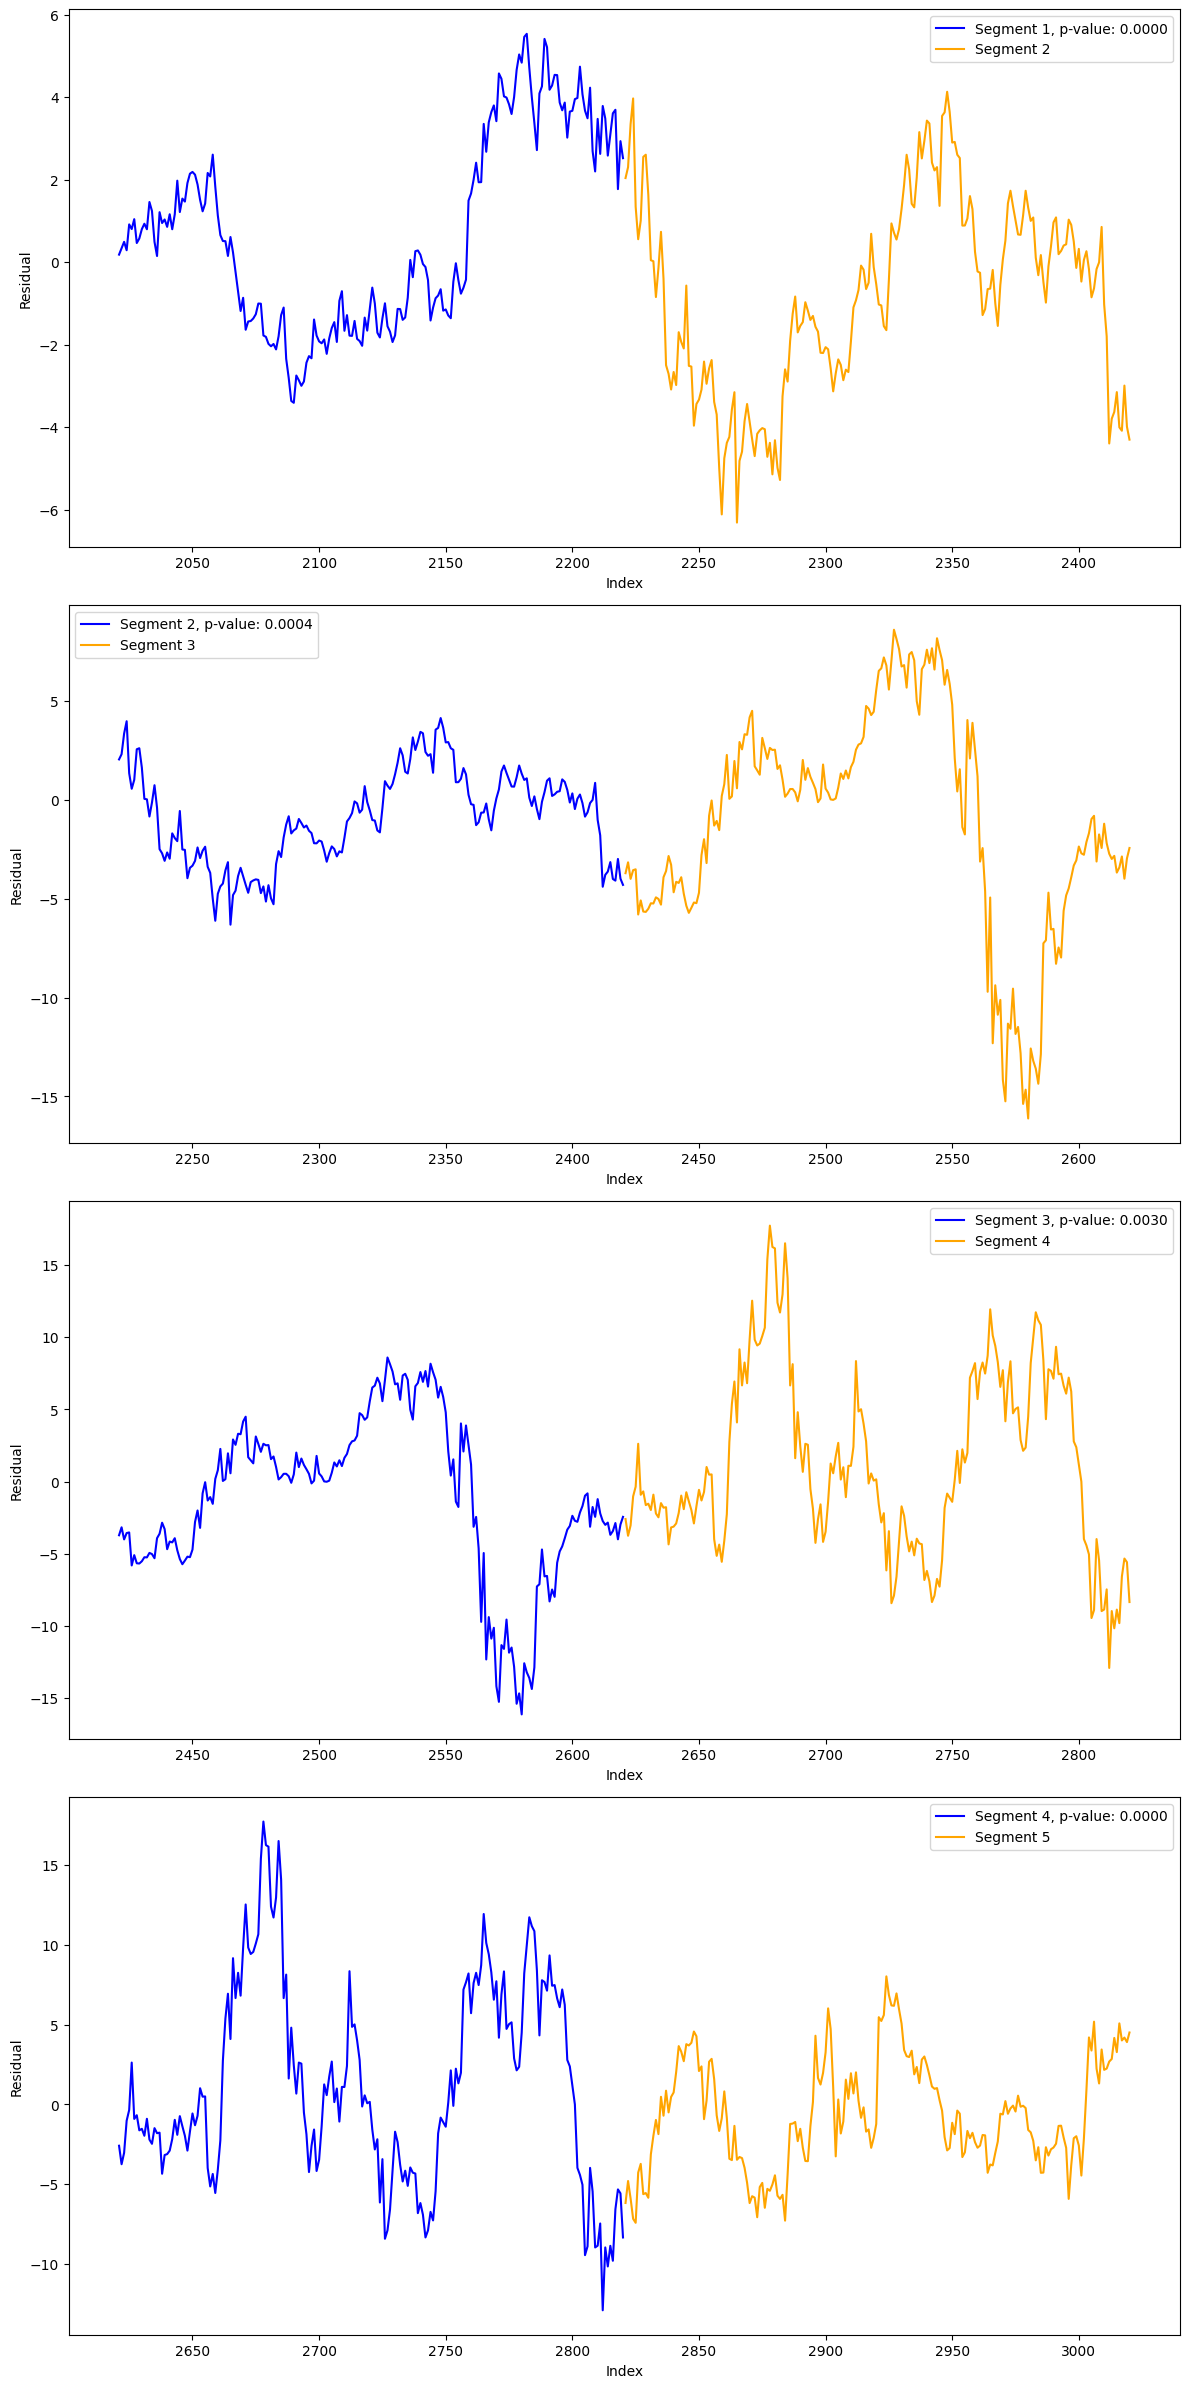

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from frouros.detectors.data_drift import KSTest
from statsmodels.tsa.seasonal import STL

class DataDriftDetector:
    def __init__(self, file_path, period=100, num_chunks=5):
        self.file_path = file_path
        self.period = period
        self.num_chunks = num_chunks
        self.data = None
        self.last_1000_data = None
        self.residual = None
        self.segments = None
        self.ks_stats = []
        self.ks_p_values = []

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def decompose_data(self):
        stl = STL(self.last_1000_data, period=self.period)
        result = stl.fit()
        self.residual = result.resid.dropna()

    def split_segments(self):
        self.segments = np.array_split(self.residual, self.num_chunks)

    def perform_ks_test(self):
        ks_test = KSTest()
        for i in range(len(self.segments) - 1):
            ks_test.fit(self.segments[i].values.reshape(-1, 1))
            ks_result, _ = ks_test.compare(self.segments[i + 1].values.reshape(-1, 1))
            ks_stat = ks_result.statistic[0]
            ks_p_value = ks_result.p_value[0]
            self.ks_stats.append(ks_stat)
            self.ks_p_values.append(ks_p_value)
            if ks_p_value < 0.05:
                print(f"Data drift detected between Segment {i+1} and Segment {i+2} (p-value: {ks_p_value:.4f})")

    def plot_results(self):
        fig, axes = plt.subplots(len(self.segments) - 1, 1, figsize=(12, 6 * (len(self.segments) - 1)))
        for i in range(len(self.segments) - 1):
            axes[i].plot(self.segments[i].index, self.segments[i], label=f'Segment {i+1}, p-value: {self.ks_p_values[i]:.4f}', color='blue')
            axes[i].plot(self.segments[i + 1].index, self.segments[i + 1], label=f'Segment {i+2}', color='orange')
            axes[i].set_xlabel('Index')
            axes[i].set_ylabel('Residual')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.decompose_data()
        self.split_segments()
        self.perform_ks_test()
        self.plot_results()

# Usage
detector = DataDriftDetector('../finance_historical.csv')
detector.run()

This analysis is focused on detecting variability changes in time series data by analyzing the rolling variance. The use of the KS test helps in identifying significant changes in the variability of the data between consecutive chunks. The rolling variance captures the variability over time, making it easier to detect shifts in the data's variability.

/home/wickstjo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Variability change detected between Chunk 1 and Chunk 2 (p-value: 0.0001)
Variability change detected between Chunk 2 and Chunk 3 (p-value: 0.0000)
Variability change detected between Chunk 3 and Chunk 4 (p-value: 0.0000)
Variability change detected between Chunk 4 and Chunk 5 (p-value: 0.0000)


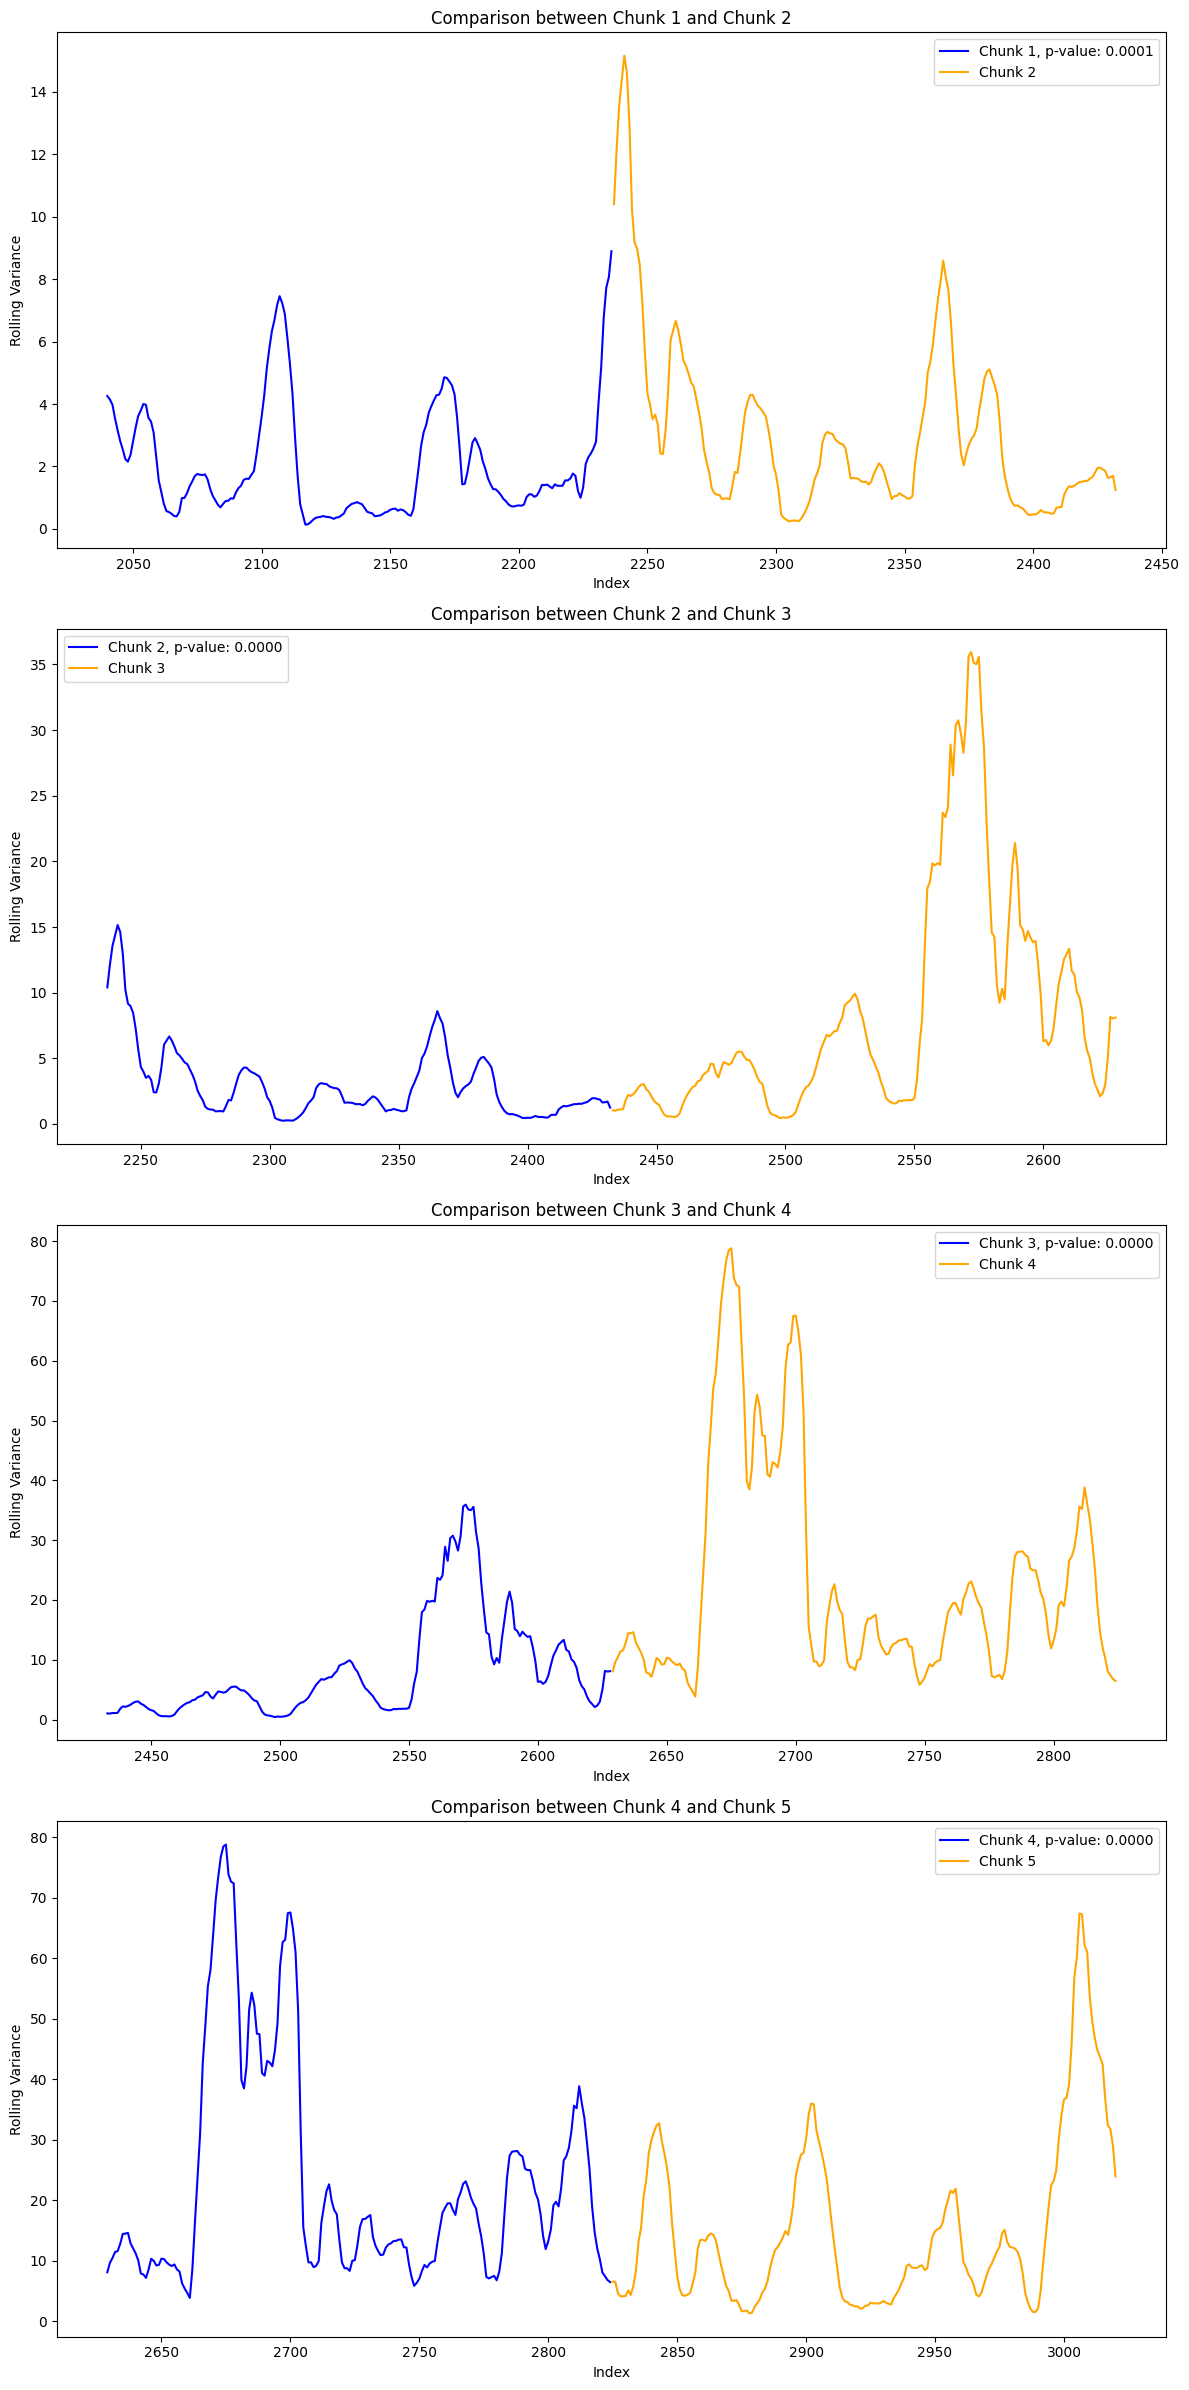

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from frouros.detectors.data_drift import KSTest

class DataDriftDetector:
    def __init__(self, file_path, window_size=20, num_chunks=5):
        self.file_path = file_path
        self.window_size = window_size
        self.num_chunks = num_chunks
        self.data = None
        self.last_1000_data = None
        self.rolling_variance = None
        self.chunks = None
        self.ks_stats = []
        self.ks_p_values = []

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def calculate_rolling_variance(self):
        self.rolling_variance = self.last_1000_data.rolling(window=self.window_size).var().dropna()

    def split_chunks(self):
        self.chunks = np.array_split(self.rolling_variance, self.num_chunks)

    def perform_ks_test(self):
        ks_test = KSTest()
        for i in range(len(self.chunks) - 1):
            ks_test.fit(self.chunks[i].values.reshape(-1, 1))
            ks_result, _ = ks_test.compare(self.chunks[i + 1].values.reshape(-1, 1))
            ks_stat = ks_result.statistic[0]
            ks_p_value = ks_result.p_value[0]
            self.ks_stats.append(ks_stat)
            self.ks_p_values.append(ks_p_value)
            if ks_p_value < 0.05:
                print(f"Variability change detected between Chunk {i+1} and Chunk {i+2} (p-value: {ks_p_value:.4f})")

    def plot_results(self):
        fig, axes = plt.subplots(len(self.chunks) - 1, 1, figsize=(12, 6 * (len(self.chunks) - 1)))
        for i in range(len(self.chunks) - 1):
            axes[i].plot(self.chunks[i].index, self.chunks[i], label=f'Chunk {i+1}, p-value: {self.ks_p_values[i]:.4f}', color='blue')
            axes[i].plot(self.chunks[i + 1].index, self.chunks[i + 1], label=f'Chunk {i+2}', color='orange')
            axes[i].set_title(f'Comparison between Chunk {i+1} and Chunk {i+2}')
            axes[i].set_xlabel('Index')
            axes[i].set_ylabel('Rolling Variance')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.calculate_rolling_variance()
        self.split_chunks()
        self.perform_ks_test()
        self.plot_results()

# Usage
detector = DataDriftDetector('../finance_historical.csv')
detector.run()

This analysis is focused on detecting structural changes in time series data by analyzing the autocorrelation function (ACF) and using the CUSUM method to detect level shifts. The ACF helps in identifying patterns and correlations within the data, while the CUSUM method detects shifts in the mean level of the data, indicating potential structural changes.

/home/wickstjo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Autocorrelation values for chunk: [ 1.          0.87985075  0.77475273  0.68177129  0.59666246  0.52611705
  0.44483275  0.37262064  0.29247944  0.24816914  0.21664045  0.17958928
  0.14489426  0.13931391  0.12624768  0.11079985  0.11225832  0.11522453
  0.10722997  0.08300388  0.08442915  0.07360653  0.05125515  0.00549635
 -0.0413009  -0.06750082 -0.11648577 -0.14625189 -0.18860553 -0.23911539
 -0.25879362 -0.26893984 -0.25917829 -0.24023014 -0.19755091 -0.16655391
 -0.14874226 -0.13833539 -0.11515378 -0.0943686  -0.07363118]
Autocorrelation values for chunk: [ 1.          0.91423381  0.84273907  0.7695868   0.70105619  0.64101126
  0.59740656  0.55732943  0.50474047  0.47137715  0.40946102  0.35930573
  0.30960982  0.25890903  0.21774539  0.17214114  0.14149468  0.10793311
  0.07929343  0.06163862  0.03780974  0.01421209 -0.01634804 -0.04096339
 -0.04560937 -0.05645745 -0.06220902 -0.06795661 -0.0619081  -0.08980589
 -0.09623294 -0.10737394 -0.11925842 -0.12236094 -0.13495099 -0.152

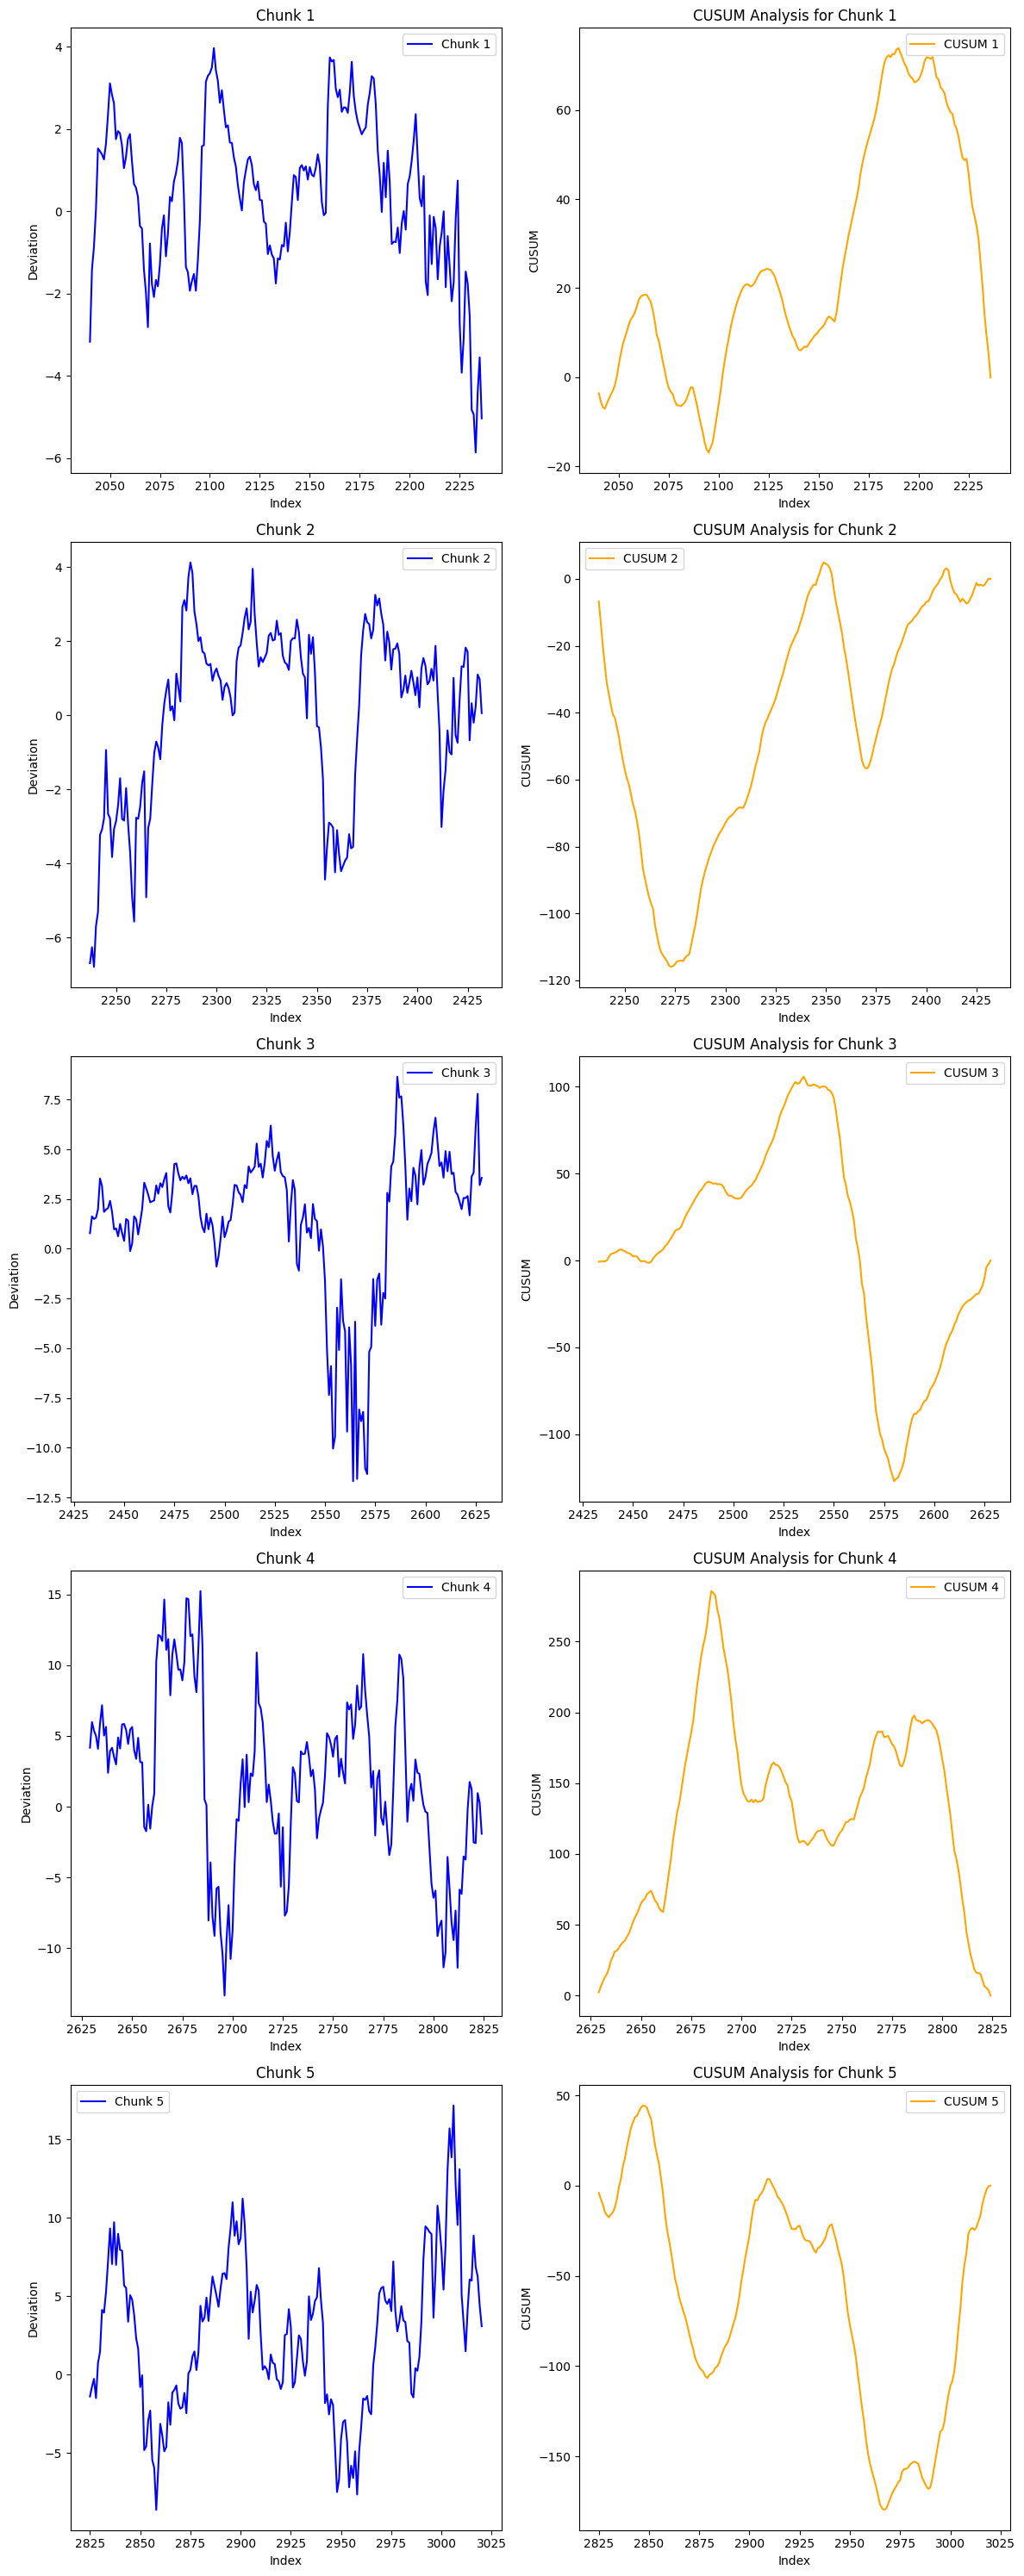

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

class DataDriftDetector:
    def __init__(self, file_path, window_size=20, num_chunks=5):
        self.file_path = file_path
        self.window_size = window_size
        self.num_chunks = num_chunks
        self.data = None
        self.last_1000_data = None
        self.moving_average = None
        self.deviations = None
        self.chunks = None
        self.acf_values = []
        self.cusum_values = []

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def calculate_moving_average(self):
        self.moving_average = self.last_1000_data.rolling(window=self.window_size).mean().dropna()

    def calculate_deviations(self):
        self.deviations = self.last_1000_data[self.window_size-1:] - self.moving_average

    def split_chunks(self):
        self.chunks = np.array_split(self.deviations, self.num_chunks)

    def perform_acf_analysis(self):
        for chunk in self.chunks:
            acf_result = acf(chunk, nlags=40)
            self.acf_values.append(acf_result)
            print(f"Autocorrelation values for chunk: {acf_result}")

    def perform_cusum_analysis(self):
        for chunk in self.chunks:
            mean = np.mean(chunk)
            cusum = np.cumsum(chunk - mean)
            self.cusum_values.append(cusum)
            print(f"CUSUM values for chunk: {cusum}")

    def plot_results(self):
        fig, axes = plt.subplots(len(self.chunks), 2, figsize=(12, 6 * len(self.chunks)))
        for i in range(len(self.chunks)):
            axes[i, 0].plot(self.chunks[i].index, self.chunks[i], label=f'Chunk {i+1}', color='blue')
            axes[i, 0].set_title(f'Chunk {i+1}')
            axes[i, 0].set_xlabel('Index')
            axes[i, 0].set_ylabel('Deviation')
            axes[i, 0].legend()

            axes[i, 1].plot(self.chunks[i].index, self.cusum_values[i], label=f'CUSUM {i+1}', color='orange')
            axes[i, 1].set_title(f'CUSUM Analysis for Chunk {i+1}')
            axes[i, 1].set_xlabel('Index')
            axes[i, 1].set_ylabel('CUSUM')
            axes[i, 1].legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.calculate_moving_average()
        self.calculate_deviations()
        self.split_chunks()
        self.perform_acf_analysis()
        self.perform_cusum_analysis()
        self.plot_results()

# Usage
detector = DataDriftDetector('../finance_historical.csv')
detector.run()

This analysis is focused on detecting distributional shifts in time series data by analyzing the deviations from a moving average. The Anderson-Darling test helps in identifying significant changes in the data distribution within each chunk, while the Wasserstein distance measures the difference in distributions between consecutive chunks. This combination provides a comprehensive approach to detecting distributional shifts in the data. 


/home/wickstjo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Distributional shift detected between Chunk 2 and Chunk 3 (AD statistic: 6.0316)
Distributional shift detected between Chunk 3 and Chunk 4 (AD statistic: 10.5313)
Wasserstein distance between Chunk 1 and Chunk 2: 0.5145
Wasserstein distance between Chunk 2 and Chunk 3: 2.0158
Wasserstein distance between Chunk 3 and Chunk 4: 2.2713
Wasserstein distance between Chunk 4 and Chunk 5: 1.0834


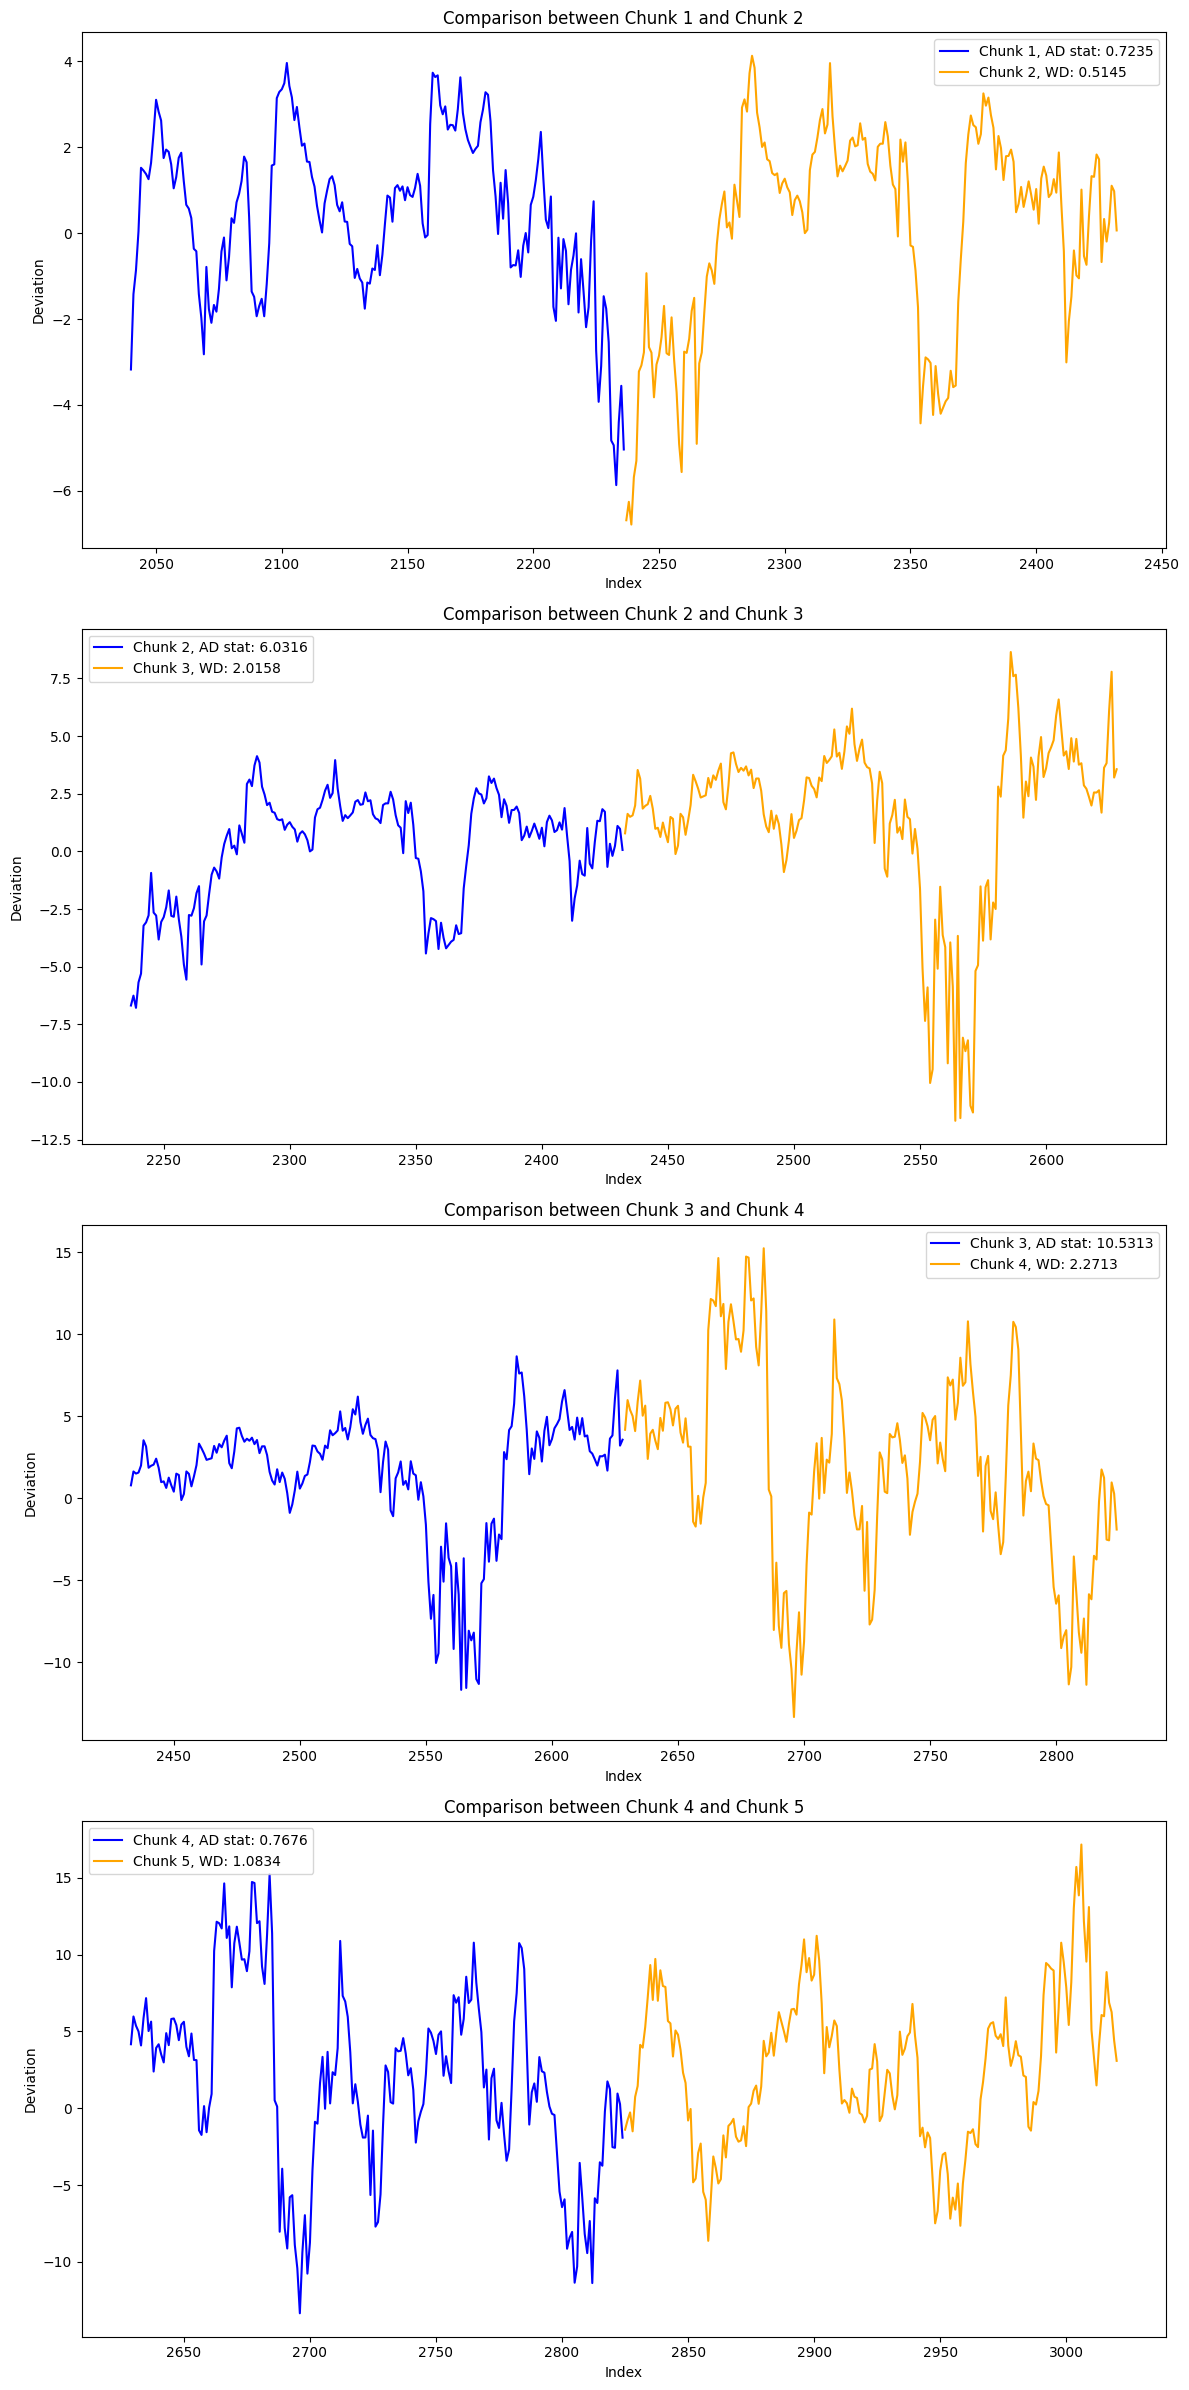

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import anderson
from scipy.stats import wasserstein_distance

class DataDriftDetector:
    def __init__(self, file_path, window_size=20, num_chunks=5):
        self.file_path = file_path
        self.window_size = window_size
        self.num_chunks = num_chunks
        self.data = None
        self.last_1000_data = None
        self.moving_average = None
        self.deviations = None
        self.chunks = None
        self.ad_stats = []
        self.ad_p_values = []
        self.wd_distances = []

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def calculate_moving_average(self):
        self.moving_average = self.last_1000_data.rolling(window=self.window_size).mean().dropna()

    def calculate_deviations(self):
        self.deviations = self.last_1000_data[self.window_size-1:] - self.moving_average

    def split_chunks(self):
        self.chunks = np.array_split(self.deviations, self.num_chunks)

    def perform_ad_test(self):
        for i in range(len(self.chunks) - 1):
            ad_result = anderson(self.chunks[i])
            ad_stat = ad_result.statistic
            ad_critical_values = ad_result.critical_values
            ad_significance_level = ad_result.significance_level
            self.ad_stats.append(ad_stat)
            self.ad_p_values.append(ad_significance_level)
            if ad_stat > ad_critical_values[2]:  # Typically, the 5% significance level is the third value
                print(f"Distributional shift detected between Chunk {i+1} and Chunk {i+2} (AD statistic: {ad_stat:.4f})")

    def perform_wd_test(self):
        for i in range(len(self.chunks) - 1):
            wd_distance = wasserstein_distance(self.chunks[i], self.chunks[i + 1])
            self.wd_distances.append(wd_distance)
            print(f"Wasserstein distance between Chunk {i+1} and Chunk {i+2}: {wd_distance:.4f}")

    def plot_results(self):
        fig, axes = plt.subplots(len(self.chunks) - 1, 1, figsize=(12, 6 * (len(self.chunks) - 1)))
        for i in range(len(self.chunks) - 1):
            axes[i].plot(self.chunks[i].index, self.chunks[i], label=f'Chunk {i+1}, AD stat: {self.ad_stats[i]:.4f}', color='blue')
            axes[i].plot(self.chunks[i + 1].index, self.chunks[i + 1], label=f'Chunk {i+2}, WD: {self.wd_distances[i]:.4f}', color='orange')
            axes[i].set_title(f'Comparison between Chunk {i+1} and Chunk {i+2}')
            axes[i].set_xlabel('Index')
            axes[i].set_ylabel('Deviation')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.calculate_moving_average()
        self.calculate_deviations()
        self.split_chunks()
        self.perform_ad_test()
        self.perform_wd_test()
        self.plot_results()

# Usage
detector = DataDriftDetector('../finance_historical.csv')
detector.run()

count    991.000000
mean       0.608150
std        2.798208
min      -12.224498
25%       -0.691000
50%        0.572001
75%        1.893256
max       11.828996
Name: close, dtype: float64


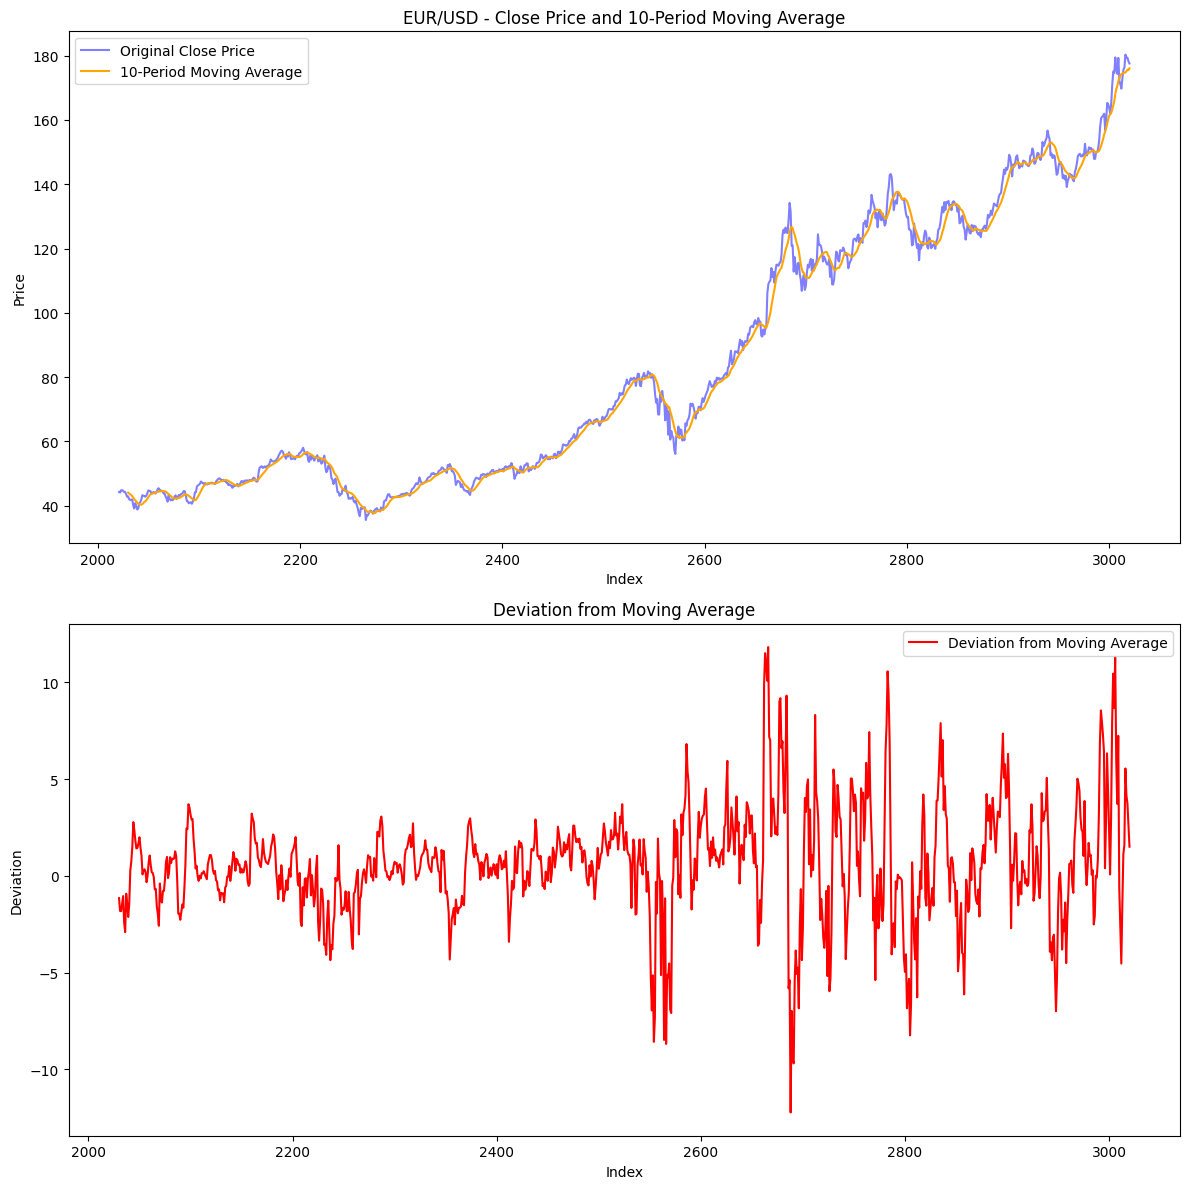

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

class MovingAverageAnalysis:
    def __init__(self, file_path, window_size=10):
        self.file_path = file_path
        self.window_size = window_size
        self.data = None
        self.last_1000_data = None
        self.moving_average = None
        self.deviations = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.last_1000_data = self.data['close'].tail(1000)

    def calculate_moving_average(self):
        self.moving_average = self.last_1000_data.rolling(window=self.window_size).mean().dropna()

    def calculate_deviations(self):
        self.deviations = self.last_1000_data[self.window_size-1:] - self.moving_average

    def print_deviations_summary(self):
        print(self.deviations.describe())

    def plot_results(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

        # Plot the original data and the moving average
        ax1.plot(self.last_1000_data.index, self.last_1000_data, label='Original Close Price', color='blue', alpha=0.5)
        ax1.plot(self.moving_average.index, self.moving_average, label=f'{self.window_size}-Period Moving Average', color='orange')
        ax1.set_title(f'EUR/USD - Close Price and {self.window_size}-Period Moving Average')
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Price')
        ax1.legend()

        # Plot the deviations on a separate subplot
        ax2.plot(self.deviations.index, self.deviations, label='Deviation from Moving Average', color='red')
        ax2.set_title('Deviation from Moving Average')
        ax2.set_xlabel('Index')
        ax2.set_ylabel('Deviation')
        ax2.legend()

        # Adjust layout
        plt.tight_layout()
        plt.show()

    def run(self):
        self.load_data()
        self.calculate_moving_average()
        self.calculate_deviations()
        self.print_deviations_summary()
        self.plot_results()


# Usage
detector = MovingAverageAnalysis('../finance_historical.csv')
detector.run()
